In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Моя модель

In [2]:
class MyLinearRegression:

    def __init__(self):
        self.__B = None

    def __gradient(self, X, y):
        return 1/X.shape[0] * (X.T @ (X @ self.__B - y))

    def __gradient_step(self, B,  alpha, gradient):
        return B - alpha*gradient

    def __check_type(self, X, y=0):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.to_numpy()
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.to_numpy().reshape((-1, 1))
        return X, y

    def fit(self, X, y, alpha=0.05, n_iters=1000):
        X, y = self.__check_type(X, y)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.__B = np.ones(X.shape[1]).reshape([-1, 1])
        for i in range(n_iters):
            error = X @ self.__B - y.reshape((-1, 1))
            if error.sum() < 0.000001:
                break
            gradient = self.__gradient(X, y)
            self.__B = self.__gradient_step(self.__B, alpha, gradient)

    def predict(self, X):
        X = self.__check_type(X)[0]
        ones = np.ones((X.shape[0], 1))
        X = np.hstack((ones, X))
        return X @ self.__B

    def score(self, X, y):
        X, y = self.__check_type(X, y)
        y_ = self.predict(X)
        return 1-(sum((y-y_)**2)/sum((y-y.mean())**2))[0]

### Анализ датасета

In [5]:
# Сперва загрузим датасет
data2 = datasets.fetch_openml("debutanizer")
data2.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
# Далее посмотрим описание датасета
print(data2["DESCR"])

&quot;The debutanizer column is part of a desulfuring and naphtha splitter plant.&quot;

u1 Top temperature
u2 Top pressure
u3 Reflux flow
u4 Flow to next process
u5 6th tray temperature
u6 Bottom temperature
u7 Bottom temperature
y Butane content in the debutanizer bottoms (Naphtha splitter feed)

See Appendix A.3 of Fortuna, L., Graziani, S., Rizzo, A., Xibilia, M.G. &quot;Fortuna, L., Graziani, S., Rizzo, A., Xibilia, M.G.&quot; (Springer 2007) for more info.

Downloaded from openml.org.


In [7]:
# Ознакомимся с содержимым датасета, делаем вывод, что наша задача - линейная регрессия
data = data2["data"]
data["target"] = data2["target"]
data.head()

,u1,u2,u3,u4,u5,u6,u7,target
0,0.268900,0.650894,0.832742,0.583420,0.784759,0.843079,0.822079,0.180295
1,0.268483,0.650140,0.852153,0.577510,0.776487,0.838605,0.822079,0.177124
2,0.267967,0.659657,0.823618,0.571600,0.764546,0.807879,0.786246,0.173618
3,0.267451,0.668338,0.808371,0.565689,0.752605,0.799606,0.786246,0.171640
4,0.266935,0.647191,0.761948,0.559779,0.745326,0.773122,0.746142,0.166972


In [8]:
# С размером: на первом этаме можно предположить, что 2394 строк может быть мало для обучения модели
data.shape

(2394, 8)

In [9]:
# Проверим данные на наличие пропущенных значений:
# Видим, что пропусков в данных нет. Кроме того, видно, что все данные выражены в численных шкалах. 
# Значит, особенной обработки данный датасет не требует, он уже достаточно чистый.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394 entries, 0 to 2393
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   u1      2394 non-null   float64
 1   u2      2394 non-null   float64
 2   u3      2394 non-null   float64
 3   u4      2394 non-null   float64
 4   u5      2394 non-null   float64
 5   u6      2394 non-null   float64
 6   u7      2394 non-null   float64
 7   target  2394 non-null   float64
dtypes: float64(8)
memory usage: 149.8 KB


In [10]:
# Теперь можно вывести основную статистику по датасету:
data.describe()

,u1,u2,u3,u4,u5,u6,u7,target
count,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000
mean,0.283894,0.667847,0.598467,0.435948,0.658086,0.620741,0.589397,0.267788
std,0.103143,0.057690,0.198581,0.138237,0.127054,0.165116,0.173251,0.158943
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.224004,0.653819,0.500390,0.363369,0.608661,0.481804,0.445001,0.169188
50%,0.263995,0.671915,0.624269,0.396288,0.694644,0.639585,0.600959,0.246857
75%,0.325607,0.690943,0.742784,0.518144,0.730119,0.755050,0.741387,0.318061
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# Выделим целевую переменную и признаки
y = data['target']
X = data.drop('target', axis=1)

In [12]:
# Выведем размерность данных
X.shape, y.shape

((2394, 7), (2394,))

In [13]:
# Разобьем выбарку на тренировочную и тестовую 
# test_size - доля тестовой выборки (в моем случае 10 процентов)
# random_state - параметр для случайной выборки одних и тех же данных при повторном запуске программы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [14]:
# Обучим модель ЛР на тренировочной выборке и проанализируем коэффициенты
# u3 и u4 - слабо влияют на модель относительно других признаков
model = LinearRegression().fit(X_train, y_train)
_ = [print(k, v) for k, v in zip(X.columns, model.coef_)]

u1 0.4586468567684671
u2 -0.37097389217457055
u3 -0.13316219492192966
u4 0.2603046930943146
u5 -0.5444226088501818
u6 -0.4225446970205622
u7 0.5429248448459054


In [15]:
# Свободный коэффициент
print("Intercept:", model.intercept_)

Intercept: 0.6503193602704289


In [16]:
# Сделаем предсказания модели и сравним первые несколько точек с target:
y_pred = model.predict(X_test)
print(y_pred[:5])
print(y_test.iloc[:5].to_numpy())

[0.31477979 0.34042927 0.29417192 0.17807249 0.28331717]
[0.20505524 0.43886597 0.31247263 0.24772766 0.38595244]


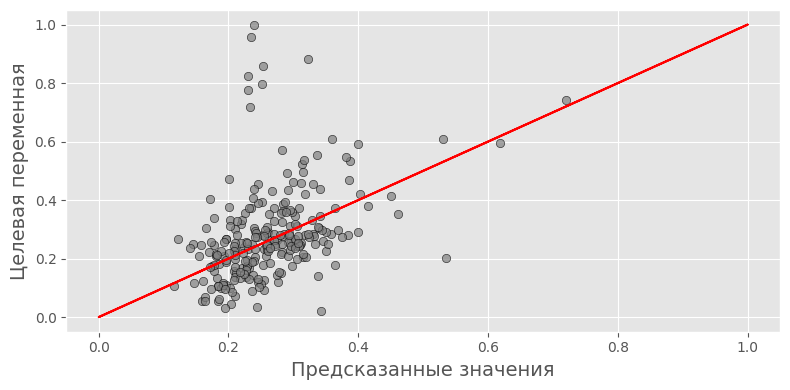

In [17]:
# Построим график для визуального анализа модели, по Ох - предсказанные значения, по Оу - целевые значения
# чем ближе точка пересечения к прямой у=х, тем лучше предсказание.
plt.style.use('default')
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
fig.tight_layout()

In [18]:
# Выведем метрики качества модели
# Напрашивается вывод: модели не хватает данных, так как на тренировочной и на тестовой выборке одинаково плохие результаты
# Модель ошибается на 50% от target
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, median_absolute_error
print(f"r2_on_train = {model.score(X_train, y_train)}")
print(f"r2 = {r2_score(y_test, y_pred)}")
print(f"MAE = {mean_absolute_error(y_test, y_pred)}")
print(f"MAPE = {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}")
print(f"MedianAE = {median_absolute_error(y_test, y_pred)}")

r2_on_train = 0.22158876508457936
r2 = 0.14226197978307886
MAE = 0.09693924011973502
MAPE = 0.49981545764039564
MSE = 0.02220321431065905
MedianAE = 0.06945542962612032


In [19]:
# Построем полиномиальную модель 3-й степени
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(poly, y, test_size=0.1, random_state=42)
polynomial = LinearRegression().fit(X_train, y_train)
y_pred_poly = polynomial.predict(X_test)

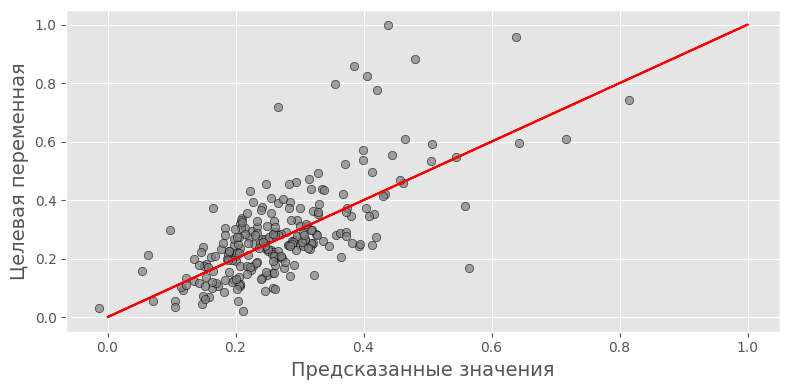

In [20]:
# Построим график для визуального анализа полиномиальной модели 3-й степени, по Ох - предсказанные значения, по Оу - целевые значения
# чем ближе точка пересечения к прямой у=х, тем лучше предсказание.
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred_poly, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
fig.tight_layout()

In [21]:
# Выведем метрики качества модели; результы улучшились но не на много, 
# при степени полинома = 4, модель становится сложнее, результаты ухудшаются - идет переобучение. 
print(f"r2 = {r2_score(y_test, y_pred_poly)}")
print(f"MAE = {mean_absolute_error(y_test, y_pred_poly)}")
print(f"MAPE = {mean_absolute_percentage_error(y_test, y_pred_poly)}")
print(f"MSE = {mean_squared_error(y_test, y_pred_poly)}")
print(f"MedianAE = {median_absolute_error(y_test, y_pred_poly)}")

r2 = 0.4682411462234356
MAE = 0.08155486483834745
MAPE = 0.3893996787856636
MSE = 0.013764990607511548
MedianAE = 0.06158186612439066


(-0.5, 1.5)

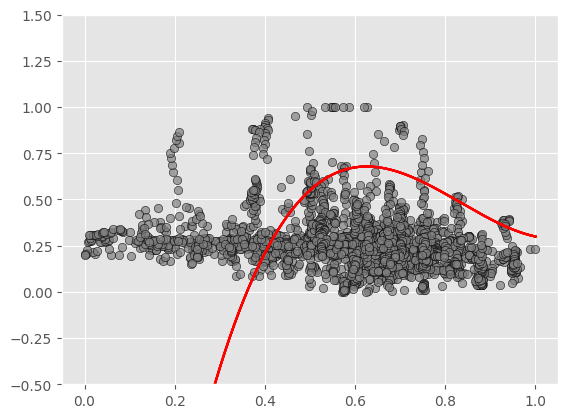

In [22]:
# Построим график регрессии для признака u3, как мы видим функция регрессии(красная линия) - это кубичиское уравнение
xx = np.linspace(X.min(), X.max(), X.shape[0]*7).reshape(-1,7)
poly = PolynomialFeatures(3)
plt.scatter(X["u3"], y, edgecolor='k', facecolor='grey', alpha=0.7,)
plt.plot(xx, polynomial.predict(poly.fit_transform(xx,y)), c='r')
plt.ylim([-0.5, 1.5])

### Обучение на разных моделях

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

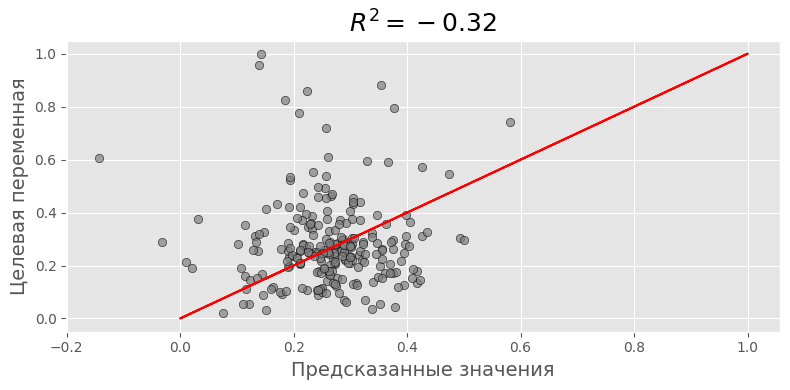

In [24]:
# Моя модель
mlr = MyLinearRegression()
mlr.fit(X_train, y_train, alpha=0.05, n_iters=1000)
y_pred = mlr.predict(X_test)

r2 = mlr.score(X_test, y_test)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

C:\Users\Саня\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


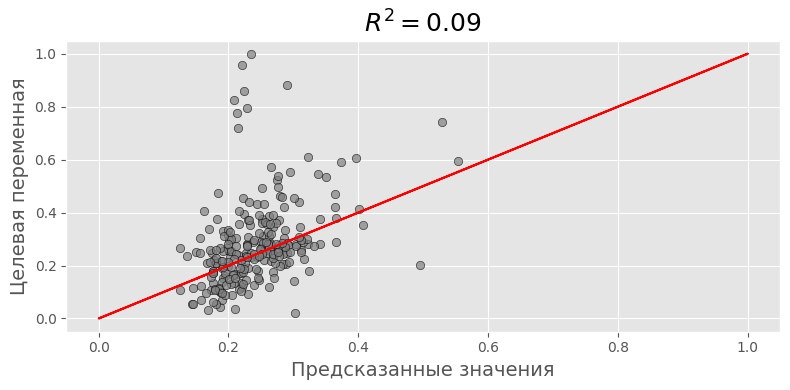

In [25]:
# Метод опорных векторов без ядра

from sklearn.svm import LinearSVR
reg = LinearSVR(random_state=0, epsilon=0, max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

C:\Users\Саня\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


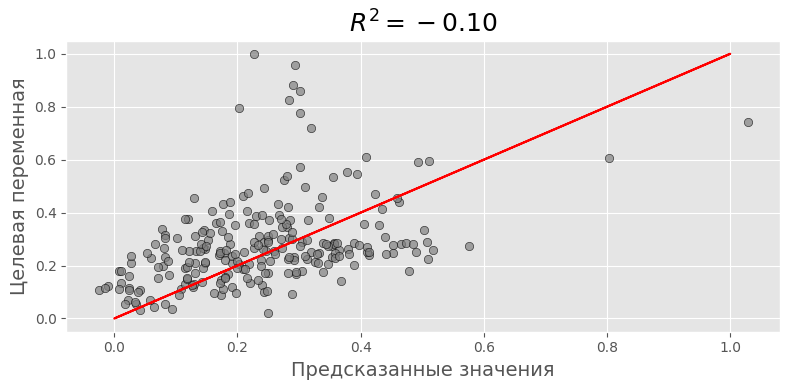

In [26]:
# Метод опорных векторов с гауссовым ядром

from sklearn.svm import SVR
reg = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1, max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

C:\Users\Саня\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


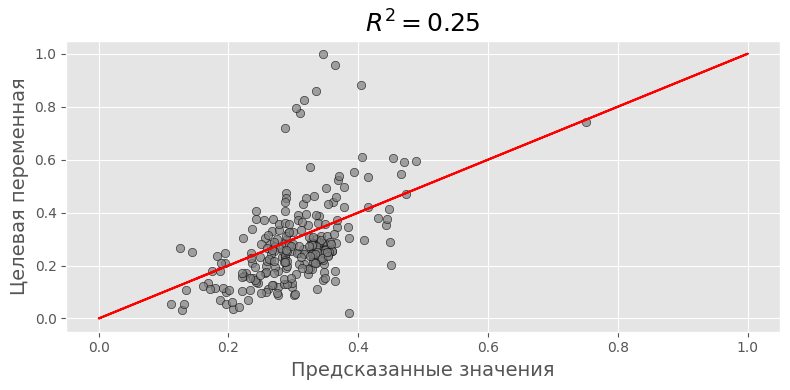

In [27]:
# Метод опорных векторов с полиномиальным ядром

reg = SVR(kernel='poly', degree=3, gamma=0.1,  C=100, epsilon=0.2, max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

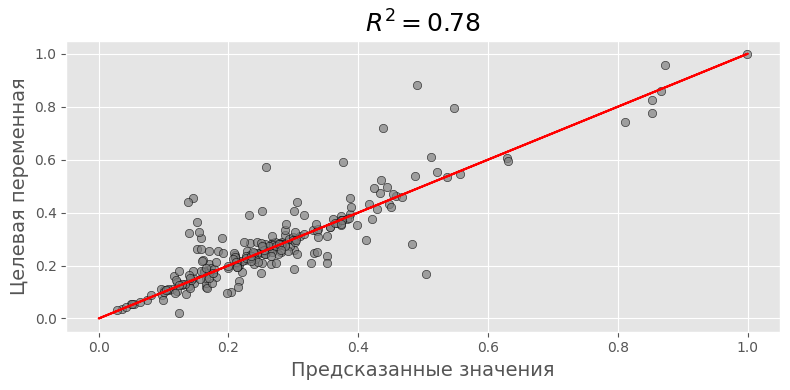

In [28]:
# Метод ближайших соседий
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor(n_neighbors=3)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

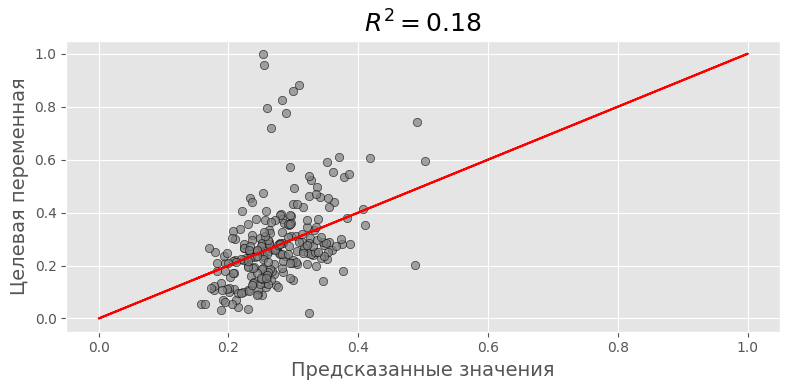

In [29]:
# Многослойный перцептрон
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

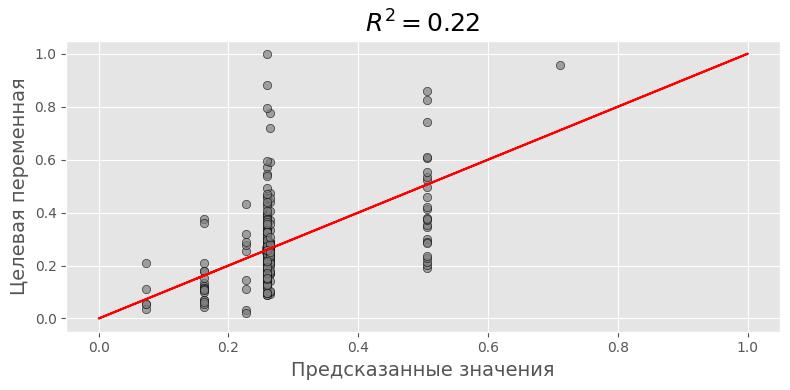

In [30]:
# Дерево решений
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(max_depth=3)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

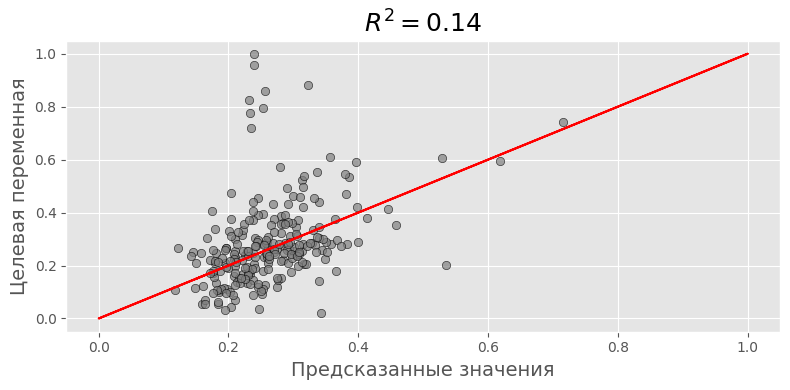

In [31]:
# Гребневая регрессию
from sklearn.linear_model import Ridge
reg = Ridge(alpha=0.1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

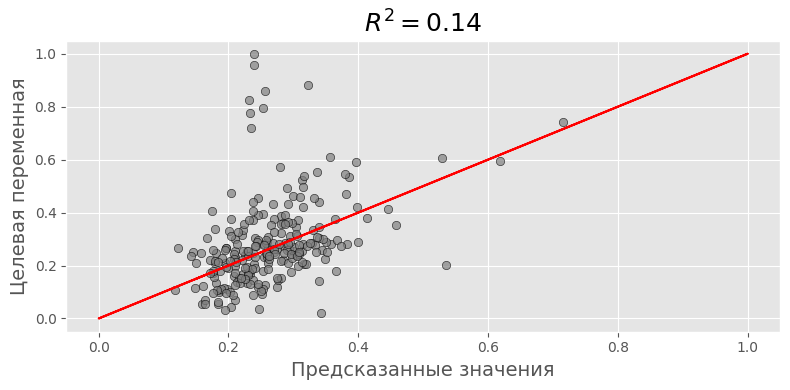

In [32]:
# Регрессия Лассо
from sklearn.linear_model import Lasso
reg = Lasso(alpha=0.1)
reg.fit(X_train, y_train)
r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

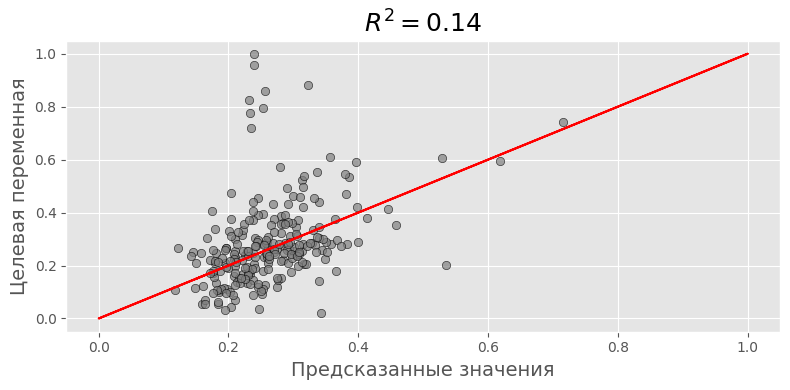

In [33]:
# Регрессия ElasticNet 
from sklearn.linear_model import ElasticNet
reg = ElasticNet(alpha=0.1, l1_ratio=0.5)
reg.fit(X_train, y_train)
r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

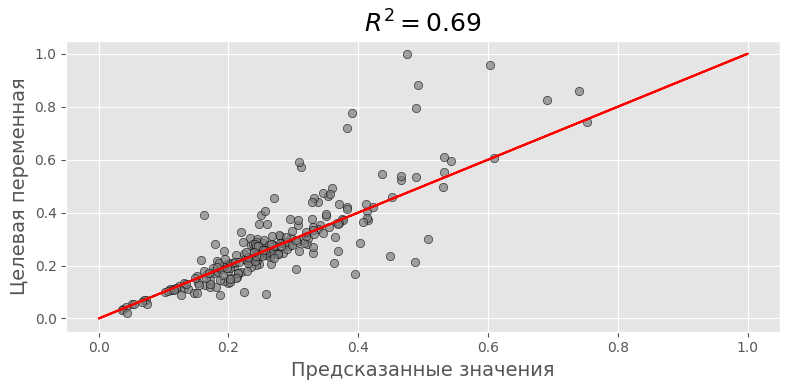

In [34]:
# Случайный лес
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=10, random_state=0)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

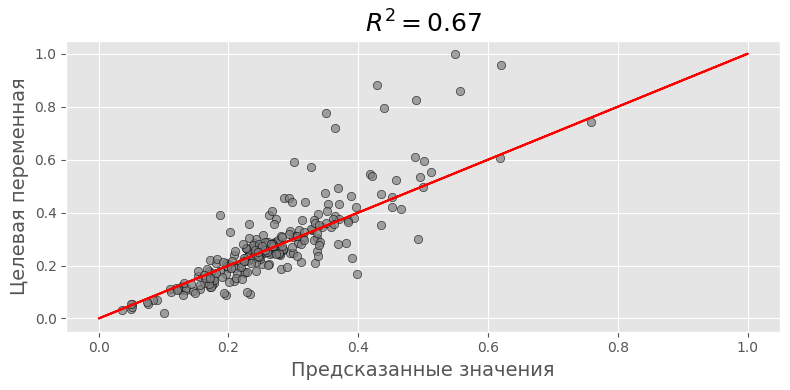

In [35]:
# Беггинг
from sklearn.ensemble import BaggingRegressor
base_model = RandomForestRegressor(n_estimators=10, random_state=0)
bagging = BaggingRegressor(base_estimator=base_model, n_estimators=10, random_state=0)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
r2 = r2_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(y, y, color='r',)
ax.scatter(y_pred, y_test, edgecolor='k', facecolor='grey', alpha=0.7,)
ax.set_ylabel('Целевая переменная', fontsize=14)
ax.set_xlabel('Предсказанные значения', fontsize=14)
ax.set_title(f'$R^2= {r2:.2f}$', fontsize=18)
fig.tight_layout()

### Выводы

Лишь 2 модели показали нормальный результат: Метод ближайших соседий и Случайный лес. Следовательно, данная задача успешнее решается через кластеризацию, а не регрессию. Для решения через регрессию, по моему мнению, стоит добавить данных